# Criação de um sismograma sintético 1D


In [1]:
# Importa as bibiliotecas necessárias
import sys  
import os
import lasio
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import resample

# Para maiores informações acessar o livro Geofísica de Exploração do Kearey pelo link
# https://drive.google.com/file/d/1Ud77JFLO0mDcC-X9pzJjC-mSDbDAzD_A/view?usp=drive_link

In [2]:
# funções auxiliares:

def dt2velC(dept, dt):
    """
    Calcula a derivada central para o cálculo da taxa de velocidade.

    Parâmetros:
    dt (list ou np.array): vetor de entrada.
    dept (float): intervalo entre os pontos do vetor.

    Retorna:
    velocidade (np.array): vetor de derivadas.
    """
    import numpy as np

    velocidade = np.zeros_like(dt)
    for i in range(1, len(dt) - 1):
        velocidade[i] = (dt[i+1] - dt[i-1]) / (dept[i+1] - dept[i-1]) 

    # As derivadas nas extremidades do vetor são calculadas usando diferenças para a frente e para trás
    velocidade[0] = (dt[1] - dt[0]) / (dept[1] - dept[0])
    velocidade[-1] = (dt[-1] - dt[-2]) / (dept[-1] - dept[-2])

    return velocidade


def dt2velP(dept, dt):
    """
    Calcula a derivada progressiva de um vetor.

    Parâmetros:
    dt (list ou np.array): vetor de entrada.
    dept (float): intervalo entre os pontos do vetor.

    Retorna:
    velocidade (np.array): vetor de derivadas.
    """
    import numpy as np

    velocidade = np.zeros_like(dt)
    for i in range(len(dt) - 1):
        velocidade[i] = (dt[i+1] - dt[i]) / (dept[i+1] - dept[i])

    # A derivada no último ponto não pode ser calculada usando uma diferença para a frente,
    # então usamos uma diferença para trás.
    velocidade[-1] = (dt[-1] - dt[-2]) / (dept[-1] - dept[-2])

    return velocidade


def impedancia_acustica(densidade, velocidade):
    """
    Calcula a impedância acústica.

    Parâmetros:
    densidade (np.array): vetor de densidades.
    velocidade (np.array): vetor de velocidades.

    Retorna:
    impedancia_acustica (np.array): vetor de impedâncias acústicas.
    """

    impedancia_acustica = np.multiply(densidade, velocidade)

    return impedancia_acustica

def taxa_amostragem(dept):
    """
    Calcula a taxa de amostragem para todo o poço.

    Parâmetros:
    dept (np.array): vetor de profundidades.

    Retorna:
    taxa_amostragem (float): taxa de amostragem para todo o poço.
    """
    # Calcula a taxa de amostragem para todo o poço
    taxa_amostragem = (dept[-1] - dept[0]) / (len(dept) - 1)

    return taxa_amostragem


def downsample(array, taxa_amostragem_atual, taxa_amostragem_desejada):
    """
    Faz o downsample de um array para uma taxa de amostragem específica.

    Parâmetros:
    array (np.array): array de entrada.
    taxa_amostragem_atual (float): taxa de amostragem atual do array.
    taxa_amostragem_desejada (float): taxa de amostragem desejada para o array (precisa ser menor do que a taxa atual do array).

    Retorna:
    array_downsampled (np.array): array após o downsample.
    """
    # Verifica e limpa os dados de entrada (nans e infs)
    array = np.nan_to_num(array)

    # Verifica se a taxa de amostragem desejada é maior que a taxa de amostragem atual
    if taxa_amostragem_desejada > taxa_amostragem_atual:
        raise ValueError("A taxa de amostragem desejada é maior que a taxa de amostragem atual.")

    # Verifica se a taxa de amostragem atual é zero ou muito próxima de zero
    if np.isclose(taxa_amostragem_atual, 0):
        raise ValueError("A taxa de amostragem atual é zero ou muito próxima de zero.")

    # Calcula o número de amostras no array downsampled
    #num_amostras = int(len(array) * taxa_amostragem_desejada / taxa_amostragem_atual)
    num_amostras = int(input("Digite o número de amostras: "))  
    print(num_amostras)

    # Faz o downsample do array
    array_downsampled = signal.resample(array, num_amostras)

    return array_downsampled

def criar_dataframe(dept, vel_resampled, rhob):
    """
    Cria um DataFrame do pandas com os dados dept, vel_resampled e rhob.

    Parâmetros:
    dept (np.array): array de profundidades.
    vel_resampled (np.array): array de velocidades após o resample.
    rhob (np.array): array de densidades.

    Retorna:
    df (pd.DataFrame): DataFrame do pandas com os dados dept, vel_resampled e rhob.
    """
    # Verifica se rhob e vel_resampled têm o mesmo tamanho
    if len(rhob) != len(vel_resampled):
        raise ValueError("rhob e vel_resampled devem ter o mesmo tamanho.")

    # Filtra os arrays para incluir apenas os elementos onde a profundidade está entre 2386 e 4344
    mask = (dept >= 2386) & (dept <= 4344)
    dept = dept[mask]
    vel_resampled = vel_resampled[mask]
    rhob = rhob[mask]

    # Cria o DataFrame
    df = pd.DataFrame({
        'Profundidade': dept,
        'Velocidade': vel_resampled,
        'Densidade': rhob
    })

    return df

def reflectividade_vp(vp, rho):
    """
    Calcula a reflectividade sísmica usando a aproximação de Aki-Richards.

    Parâmetros:
    vp (np.array): vetor de velocidades de onda P.
    rho (np.array): vetor de densidades.

    Retorna:
    R (np.array): vetor de reflectividades sísmicas.
    """
    # Calcula as diferenças de vp e rho
    delta_vp = np.diff(vp)
    delta_rho = np.diff(rho)

    # Calcula as médias de vp e rho
    vp_medio = 0.5 * (vp[:-1] + vp[1:])
    rho_medio = 0.5 * (rho[:-1] + rho[1:])

    # Calcula a reflectividade
    R = 0.5 * (delta_vp / vp_medio + delta_rho / rho_medio)

    return R


def reflectividade_imp(imp_acustica):
    """
    Calcula a reflectividade sísmica a partir da impedância acústica.

    Parâmetros:
    imp_acustica (np.array): vetor de impedâncias acústicas.

    Retorna:
    R (np.array): vetor de reflectividades sísmicas.
    """
    # Calcula a diferença de impedância acústica
    delta_Z = np.diff(imp_acustica)

    # Repete o último valor
    delta_Z = np.append(delta_Z, delta_Z[-1])

    # Calcula a média de impedância acústica
    Z_medio = 0.5 * (imp_acustica[:-1] + imp_acustica[1:])

    # Calcula a reflectividade
    R = delta_Z / Z_medio

    # Gera um aviso se o tamanho de R é diferente do tamanho de imp_acustica
    if R.size != imp_acustica.size:
        warnings.warn("O tamanho de R é diferente do tamanho de imp_acustica")

    return R

def coef_refletividade(impedancia_acustica):
    """
    Calcula o coeficiente de refletividade.

    Parâmetros:
    impedancia_acustica (np.array): vetor de impedâncias acústicas.

    Retorna:
    coef_refletividade (np.array): vetor de coeficientes de refletividade.
    """
    # Inicializa o vetor de coeficientes de refletividade
    coef_refletividade = np.zeros_like(impedancia_acustica)

    # Calcula o coeficiente de refletividade para cada par de valores consecutivos
    for i in range(1, len(impedancia_acustica)):
        coef_refletividade[i] = (impedancia_acustica[i] - impedancia_acustica[i-1]) / (impedancia_acustica[i] + impedancia_acustica[i-1])

    return coef_refletividade

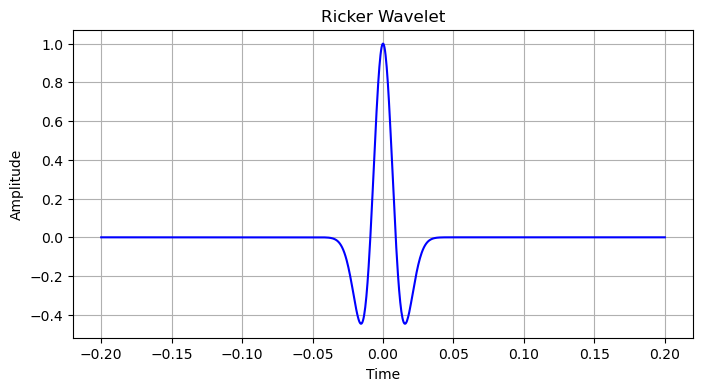

In [3]:
## Função da Fonte Ricker
def ricker_wavelet(t, f):
    """
    Generate a Ricker wavelet.

    Parameters:
    t (numpy array): Time array.
    f (float): Center frequency of the wavelet.

    Returns:
    numpy array: Ricker wavelet.
    """
    A = (1 - 2 * np.pi ** 2 * f ** 2 * t ** 2) * np.exp(-np.pi ** 2 * f ** 2 * t ** 2)
    return A

# Parameters
f = 25  # Center frequency of the Ricker wavelet
t = np.linspace(-0.2, 0.2, 1000)  # Time array

# Generate Ricker wavelet
ricker = ricker_wavelet(t, f)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(t, ricker, color='blue')
plt.title('Ricker Wavelet')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [4]:
# Leitura dos dados de entrada
dt = lasio.read('../inputs/1ess53ess_1.las')
rhob = lasio.read('../inputs/1ess53ess_2.las')

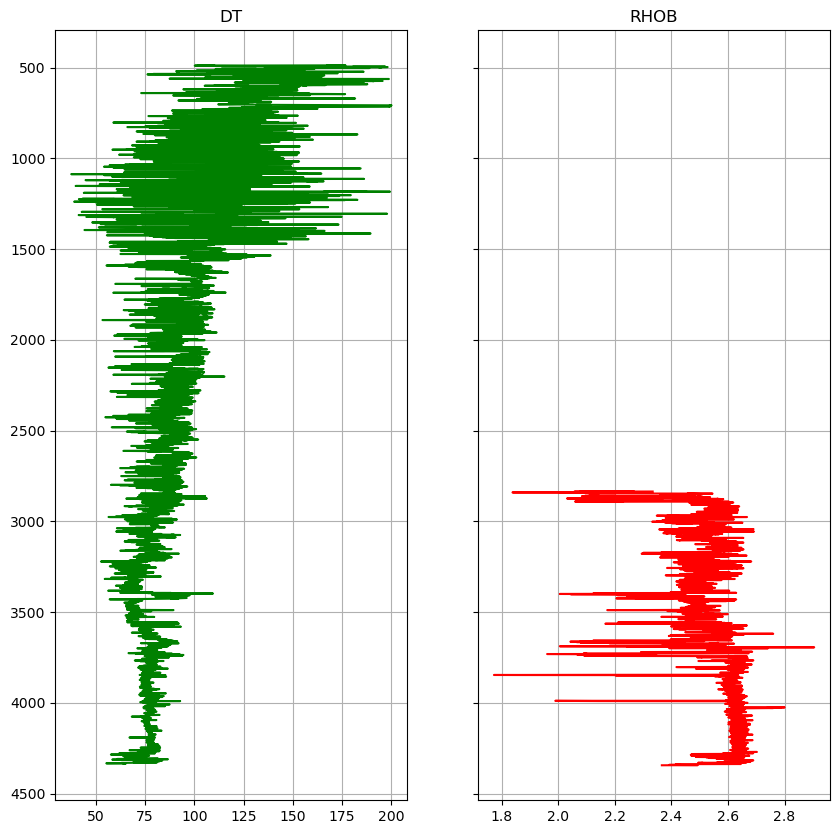

In [5]:
dt.header

# Acessar os dados
depth1 = dt['DEPTH']
track1 = dt['DT']
depth2 = rhob['DEPTH']  
track2 = rhob['RHOB']

# Criar os gráficos
fig, axs = plt.subplots(1, 2, figsize=(10,10), sharey=True)

# Primeiro gráfico
axs[0].plot(track1, depth1,'g')
axs[0].set_title('DT') 
axs[0].grid(True)

# Segundo gráfico
axs[1].plot(track2, depth2,'r')
axs[1].set_title('RHOB')  
axs[1].grid(True)


plt.gca().invert_yaxis()  # Inverter o eixo y para que a profundidade aumente para baixo
plt.show()

In [6]:
# Calcular a velocidade
vel1 = dt2velC(depth1, track1)
vel2 = dt2velP(depth1, track1)
vel3 = 1/track1

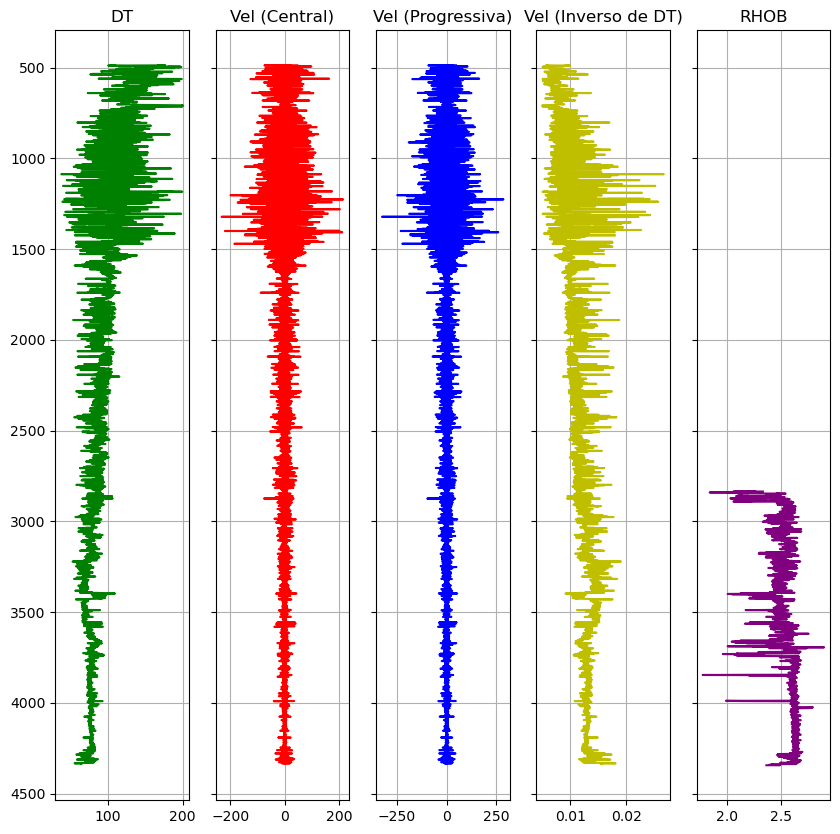

In [7]:
# Acessar os dados
depth1 = dt['DEPTH']
track1 = dt['DT']
depth2 = rhob['DEPTH']
track2 = rhob['RHOB']

# Criar os gráficos
fig, axs = plt.subplots(1, 5, figsize=(10,10), sharey=True)

# Primeiro gráfico
axs[0].plot(track1, depth1,'g')
axs[0].set_title('DT') 
axs[0].grid(True)

# Segundo gráfico
axs[1].plot(vel1, depth1,'r')
axs[1].set_title('Vel (Central)')  
axs[1].grid(True)

# Terceiro gráfico
axs[2].plot(vel2, depth1,'b')
axs[2].set_title('Vel (Progressiva)')  
axs[2].grid(True)

# Quarto gráfico
axs[3].plot(vel3, depth1,'y')
axs[3].set_title('Vel (Inverso de DT)')  
axs[3].grid(True)

# Quinto gráfico
axs[4].plot(track2, depth2,'purple')
axs[4].set_title('RHOB')
axs[4].grid(True)

plt.gca().invert_yaxis()  # Inverter o eixo y para que a profundidade aumente para baixo
plt.show()

In [8]:
# Estudo da taxa de amostragem:
taxa_vel = taxa_amostragem(depth1)
taxa_rhob = taxa_amostragem(depth2)
print(f'Taxa de amostragem de DT: {taxa_vel}')
print(f'Taxa de amostragem de RHOB: {taxa_rhob}')
print(f'As taxas de amostragem são iguais? {taxa_vel == taxa_rhob}')
#print(f'As taxas de amostragem são diferentes? {taxa_vel != taxa_rhob}')
print(f'As taxas de amostragem são aproximadamente iguais? {np.isclose(taxa_vel, taxa_rhob)}')
#print(f'As taxas de amostragem são aproximadamente diferentes? {not np.isclose(taxa_vel, taxa_rhob)}')
print(f'Qual é o primeiro valor de profundidade do sônico? {depth1[0]}')
print(f'Qual é o primeiro valor de profundidade da densidade? {depth2[0]}')
print(f'Os valores de profundidade são iguais? {depth1[0] == depth2[0]}')
#print(f'Os valores de profundidade são diferentes? {depth1[0] != depth2[0]}')
print(f'Qual é o último valor de profundidade do sônico? {depth1[-1]}')
print(f'Qual é o último valor de profundidade da densidade? {depth2[-1]}')

Taxa de amostragem de DT: 0.19999998960444929
Taxa de amostragem de RHOB: 0.20000001325732475
As taxas de amostragem são iguais? False
As taxas de amostragem são aproximadamente iguais? True
Qual é o primeiro valor de profundidade do sônico? 487.0
Qual é o primeiro valor de profundidade da densidade? 2835.7998
Os valores de profundidade são iguais? False
Qual é o último valor de profundidade do sônico? 4334.7998
Qual é o último valor de profundidade da densidade? 4344.3999


In [9]:
print('########################## OPERAÇÃO DE REAMOSTRAGEM #############################')
# Resample da velocidade:
vel3_resampled = downsample(vel3, 1, taxa_vel)
depth1_resampled = downsample(depth1, 1, taxa_vel)
print(f'Número de amostras de velocidade antes do resample: {len(vel1)}')
print(f'Número de amostras de velocidade após o resample: {len(vel3_resampled)}')
print(f'Taxa de amostragem de velocidade antes do resample: {taxa_vel}')
print(f'Taxa de amostragem de velocidade após o resample: {taxa_amostragem(depth1_resampled)}')

print('-'*80)
# Resample da densidade:
rhob_resampled = downsample(track2, 1, taxa_vel)
depth2_resampled = downsample(depth2, 1, taxa_vel)
print(f'Número de amostras de densidade antes do resample: {len(track2)}')
print(f'Número de amostras de densidade após o resample: {len(rhob_resampled)}')
print(f'Taxa de amostragem de densidade antes do resample: {taxa_rhob}')
print(f'Taxa de amostragem de densidade após o resample: {taxa_amostragem(depth2_resampled)}')


########################## OPERAÇÃO DE REAMOSTRAGEM #############################


KeyboardInterrupt: Interrupted by user

In [ ]:
# Criar os gráficos
fig, axs = plt.subplots(1, 3, figsize=(10,10), sharey=True)

# Primeiro gráfico
axs[0].plot(vel3, depth1,'y.')
axs[0].set_title('Vel (Inverso de DT)')  
axs[0].grid(True)

# Segundo gráfico
axs[1].plot(vel3_resampled, depth1_resampled,'b.')
axs[1].set_title('Vel (Resampled)') 
axs[1].grid(True)

# Terceiro gráfico
axs[2].plot(rhob_resampled, depth2_resampled,'k.')
axs[2].set_title('RHOB')
axs[2].grid(True)


plt.gca().invert_yaxis()  # Inverter o eixo y para que a profundidade aumente para baixo
plt.show()

In [ ]:
# Cria um novo DataFrame com os dados reamostrados
df = criar_dataframe(depth2_resampled, vel3_resampled, rhob_resampled)
print(df.head())

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plota velocidade versus profundidade
axs[0].plot(df['Profundidade'], df['Velocidade'], 'b.')
axs[0].set_ylabel('Velocidade')
axs[0].grid(True)

# Plota rhob versus profundidade
axs[1].plot(df['Profundidade'], df['Densidade'], 'k.')
axs[1].set_xlabel('Profundidade')
axs[1].set_ylabel('Rhob')
axs[1].grid(True)

    
plt.gca().invert_yaxis()  # Inverter o eixo y para que a profundidade aumente para baixo
plt.show()

In [ ]:
#Calcula a impedância acústica
imp_acustica = impedancia_acustica(df['Densidade'], df['Velocidade'])

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plota velocidade versus profundidade
axs[0].plot(df['Profundidade'], df['Velocidade'], 'b.')
axs[0].set_ylabel('Velocidade')
axs[0].grid(True)

# Plota rhob versus profundidade
axs[1].plot(df['Profundidade'], df['Densidade'], 'k.')
axs[1].set_xlabel('Profundidade')
axs[1].set_ylabel('Rhob')
axs[1].grid(True)

# Plota impedância versus profundidade
axs[2].plot(df['Profundidade'], imp_acustica, 'g.')
axs[2].set_xlabel('Profundidade')
axs[2].set_ylabel('Impedância Acústica')
axs[2].grid(True)

    
plt.gca().invert_yaxis()  # Inverter o eixo y para que a profundidade aumente para baixo
plt.show()

# Reflectividade Sísmica

A reflectividade sísmica é uma medida de quão bem uma interface entre dois materiais pode refletir ondas sísmicas. Ela é comumente calculada usando a fórmula de Zoeppritz, mas uma aproximação comum é a fórmula de Shuey, que é mais simples e mais fácil de calcular.

A fórmula de Shuey para a reflectividade R é:

$R = (\dfrac{ΔVp}{Vp} + \dfrac{Δρ}{2ρ}) + (\dfrac{ΔVp}{Vp} - \dfrac{2Vp²}{Vs²} \times \dfrac{Δρ}{ρ}) \times sin²(\theta)$

onde:

* ΔVp é a mudança na velocidade de onda P entre as duas camadas
* Δρ é a mudança na densidade entre as duas camadas
* Vp é a velocidade de onda P média entre as duas camadas
* Vs é a velocidade de onda S média entre as duas camadas
* $\theta$ é o ângulo de incidência da onda sísmica

No entanto, se você não tiver informações sobre a velocidade da onda S (Vs), você pode usar a aproximação de Aki-Richards, que ignora o termo Vs:

$R = 0.5 * (\dfrac{ΔVp}{Vp} + \dfrac{Δρ}{ρ})$

A impedância acústica (Z) é um parâmetro fundamental no cálculo da reflectância. Ela é definida como o produto da densidade (ρ) de uma camada pelo módulo de velocidade de onda P (Vp) nessa camada. A fórmula para a impedância acústica é:

$Z = ρ \times Vp$

A reflectância (R) na interface entre duas camadas é então calculada a partir da diferença de impedância acústica (ΔZ) entre as duas camadas e a média de impedância acústica (Zm) entre as duas camadas, conforme a seguinte fórmula:

$R = \dfrac{ΔZ}{Zm} = \dfrac{(Z2 - Z1)}{ \frac{(Z1 + Z2)}{2}}$

onde Z1 e Z2 são as impedâncias acústicas das duas camadas.

Portanto, se você tiver os valores de impedância acústica, você pode calcular a reflectância diretamente a partir deles, sem precisar dos valores individuais de velocidade e densidade.

In [ ]:
# Calculo da Reflectividade sísmica

print(len(df['Velocidade']), len(df['Densidade']), len(imp_acustica))
    
#Rvp = reflectividade_vp(df['Velocidade'], df['Densidade'])
Rimp = reflectividade_imp(imp_acustica)


fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

# Plota velocidade versus profundidade
axs[0].plot(df['Profundidade'], df['Velocidade'], 'b.')
axs[0].set_ylabel('Velocidade')
axs[0].grid(True)

# Plota rhob versus profundidade
axs[1].plot(df['Profundidade'], df['Densidade'], 'k.')
axs[1].set_ylabel('Rhob')
axs[1].grid(True)

# Plota impedância versus profundidade
axs[2].plot(df['Profundidade'], imp_acustica, 'g.')
axs[2].set_ylabel('Impedância Acústica')
axs[2].grid(True)

# Plota Refletividade versus profundidade
axs[3].plot(df['Profundidade'], Rimp, 'r.')
axs[3].set_ylabel('Reflectividade')
axs[3].set_xlabel('Profundidade')
axs[3].grid(True)

    
plt.gca().invert_yaxis()  # Inverter o eixo y para que a profundidade aumente para baixo
plt.show()

In [ ]:
#Calcula o coeficiente de refletividade
coef_refletividade = coef_refletividade(imp_acustica)

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 8))

# Plota velocidade versus profundidade
axs[0].plot(df['Profundidade'], df['Velocidade'], 'b.')
axs[0].set_ylabel('Velocidade')
axs[0].grid(True)

# Plota rhob versus profundidade
axs[1].plot(df['Profundidade'], df['Densidade'], 'k.')
axs[1].set_ylabel('Rhob')
axs[1].grid(True)

# Plota impedância versus profundidade
axs[2].plot(df['Profundidade'], imp_acustica, 'g.')
axs[2].set_ylabel('Impedância Acústica')
axs[2].grid(True)

# Plota Refletividade versus profundidade
axs[3].plot(df['Profundidade'], Rimp, 'r.')
axs[3].set_ylabel('Reflectividade')
axs[3].grid(True)

# Plota coef de reflet versus profundidade
axs[4].plot(df['Profundidade'], coef_refletividade, 'y.')
axs[4].set_ylabel('Coef. de Reflet')
axs[4].set_xlabel('Profundidade')
axs[4].grid(True)

    
plt.gca().invert_yaxis()  # Inverter o eixo y para que a profundidade aumente para baixo
plt.show()